## Pulse Parameterization

### Amplitude Function

Often times, the optimization parameters are not exactly the amplitudes in the
Hamilton operator but can be mapped by differentiable functions.

One prominent example is IQ-modulated control in rabi driving. Lets assume the
Hamiltonian

\begin{equation}
H = \frac{\hbar \omega_0}{2} \sigma_z + \hbar A \text{sin}(\omega t + \delta)
\sigma_x,
\end{equation}

where $\omega_0$ is the resonance frequency, $A$ the driving amplitude and
$\delta$ the phase shift of the driving signal.
change into the rotating frame by transforming with

\begin{equation}
U(t) =
\begin{pmatrix}
e^{-i\omega_0 t / 2} & 0 \\
0 & e^{i\omega_0 t / 2}
\end{pmatrix}
\end{equation}


and apply the rotating wave approximation to get

\begin{equation}
H = \frac{\hbar A}{2} \text{cos} (\delta ) \sigma_x
+ \frac{\hbar A}{2} \text{sin} (\delta ) \sigma_y.
\end{equation}

Our optimization parameters are now $(A, \delta)$ and the amplitudes in our
control hamiltonian are $(\frac{\hbar A}{2} \text{cos} (\delta ),
\frac{\hbar A}{2} \text{sin} (\delta ))$. We can use the class
AmplitudeFunction to implement an interface to our amplitude functions.


In [1]:
import numpy as np
from qopt.amplitude_functions import CustomAmpFunc


n_time_steps = 10
n_opt_pars = 2
n_ctrl_amps = 2

def amp_func(opt_pars):
    ctrl_amps = np.empty((opt_pars.shape[0], n_ctrl_amps))
    ctrl_amps[:, 0] = .5 * opt_pars[:, 0] * np.cos(opt_pars[:, 1])
    ctrl_amps[:, 1] = .5 * opt_pars[:, 0] * np.sin(opt_pars[:, 1])
    return ctrl_amps

def deriv_amp_func(opt_pars):
    ctrl_amps_deriv = np.empty((opt_pars.shape[0], n_opt_pars, n_ctrl_amps))

    ctrl_amps_deriv[:, 0, 0] = .5 * np.cos(opt_pars[:, 1])
    ctrl_amps_deriv[:, 0, 1] = .5 * np.sin(opt_pars[:, 1])

    ctrl_amps_deriv[:, 1, 0] = -.5 * opt_pars[:, 0] * np.sin(opt_pars[:, 1])
    ctrl_amps_deriv[:, 1, 1] = .5 * opt_pars[:, 0] * np.cos(opt_pars[:, 1])

    return ctrl_amps_deriv

amplitude_function = CustomAmpFunc(
    value_function=amp_func,
    derivative_function=deriv_amp_func
)

We also need to implement the derivative, which will be used later in the
newton type optimization algorithms.

### Transfer Function

If we now want to take our simulation another step closer to a real experiment,
we can additionally simulate the imperfections of control electronics with a
transfer function. Let's assume for example that we cannot change the amplitude
$A$ and the phase $\delta$ of our control pulse arbitrarily fast, but need some
time.

This can be simulated for example with the assumptions that the actual changes
will have the shape of an exponential saturation. The transfer function does
the following. It oversamples the pulse, meaning that it divides each time step
in a number of smaller time steps, and then applies the applies the requested
function to the values of the finer time steps.

In [2]:
from qopt.transfer_function import ExponentialMTF
rise_time = .02
oversampling = 10
transfer_func = ExponentialMTF(
    awg_rise_time=rise_time,
    oversampling=oversampling,
    num_ctrls=n_ctrl_amps
)

total_time = 1
time_steps = (total_time / n_time_steps) * np.ones((n_time_steps, ))

transfer_func.set_times(time_steps)

It is important to set the time steps in the transfer function, such that the
transferred time steps are known within the program. They will also overwrite
the time steps set to the solver class.

Other transfer functions are also supplied. For example the transfer by
application of a Gaussian filter.

Lets consider again a pulse with random amplitude and a constant phase to have
a look at the effects of the transfer and amplitude function.

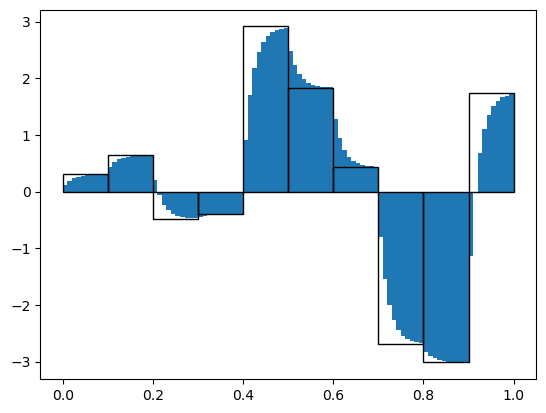

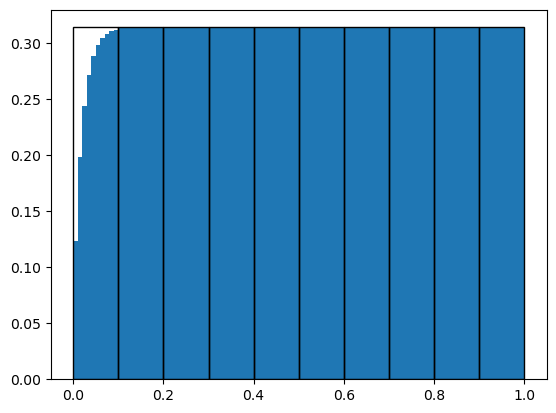

Text(0, 0.5, 'Control Amplitude (a.u.)')

In [3]:
import matplotlib.pyplot as plt
np.random.seed(0)
random_pulse = np.pi * 2 * (np.random.rand(n_time_steps, n_ctrl_amps) - .5)
random_pulse[:, 1] = .1 * np.pi

transfer_func.plot_pulse(random_pulse)
plt.plot(amplitude_function(transfer_func(random_pulse)))
plt.title('After Application of Transfer and Amplitude Function')
plt.xlabel('Time (a.u.)')
plt.ylabel('Control Amplitude (a.u.)')


For the optimization we can give the transfer and amplitude function as
attributes to the solver class.

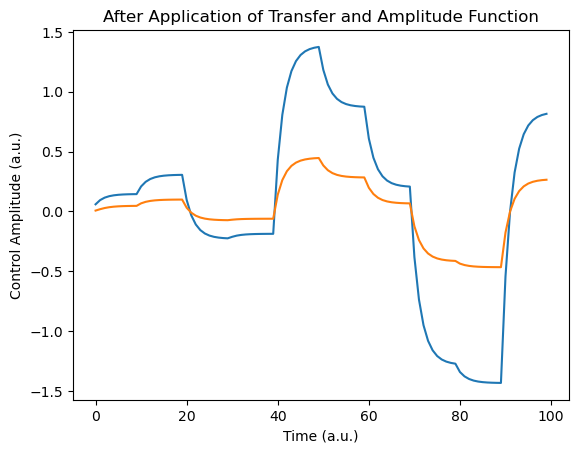

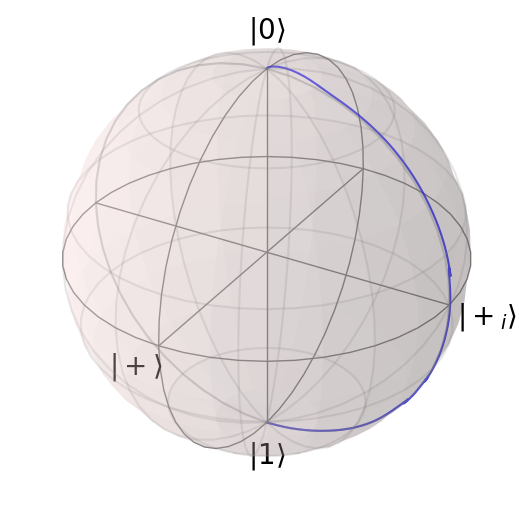

In [4]:
from qopt.matrix import DenseOperator
from qopt.solver_algorithms import SchroedingerSolver
from qopt.cost_functions import OperationInfidelity


sigma_x = DenseOperator(np.asarray([[0, 1], [1, 0]]))
sigma_y = DenseOperator(np.asarray([[0, -1j], [1j, 0]]))
sigma_z = DenseOperator(np.asarray([[1, 0], [0, -1]]))

delta_omega = 0

h_ctrl = [.5 * sigma_x, .5 * sigma_y]
h_drift = [delta_omega * .5 * sigma_z]

solver = SchroedingerSolver(
    h_drift=h_drift,
    h_ctrl=h_ctrl,
    tau=time_steps,
    transfer_function=transfer_func,
    amplitude_function=amplitude_function
)

entanglement_infidelity = OperationInfidelity(
    solver=solver,
    target=sigma_x.exp(np.pi * .5j)
)

from qopt.simulator import Simulator

simulator = Simulator(
    solvers=[solver, ],
    cost_funcs=[entanglement_infidelity, ]
)

from qopt.optimize import LeastSquaresOptimizer

termination_conditions = {
    "min_gradient_norm": 1e-15,
    "min_cost_gain": 1e-15,
    "max_wall_time": 30.0,
    "max_cost_func_calls": 1e6,
    "max_iterations": 1000,
    "min_amplitude_change": 1e-8
}

upper_bounds = 2 * 2 * np.pi * np.ones((len(h_ctrl) * n_time_steps, ))
lower_bounds = -1 * upper_bounds

optimizer = LeastSquaresOptimizer(
    system_simulator=simulator,
    termination_cond=termination_conditions,
    save_intermediary_steps=True,
    bounds=[lower_bounds, upper_bounds]
)

result = optimizer.run_optimization(initial_control_amplitudes=random_pulse)
solver.set_optimization_parameters(result.final_parameters)
solver.plot_bloch_sphere()
plt.show()

In [5]:
entanglement_infidelity.costs()

1.6869572405653344e-10

And the optimized control amplitudes are:

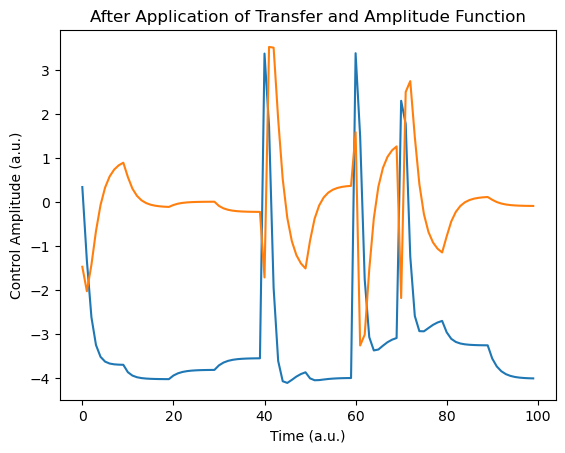

In [6]:
parameters = amplitude_function(transfer_func(result.final_parameters))
plt.plot(np.arange(len(parameters[:, 0])), parameters[:, 0])
plt.plot(np.arange(len(parameters[:, 0])), parameters[:, 1])
plt.title('After Application of Transfer and Amplitude Function')
plt.xlabel('Time (a.u.)')
plt.ylabel('Control Amplitude (a.u.)')
plt.show()


